In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q tensorflow scikit-learn matplotlib seaborn

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'tensorflow'

In [16]:
import os
import shutil

base = "/content/drive/MyDrive/Final_year_project/Optic Glioma/disease_images"
class_dir = os.path.join(base, "optic_glioma")

os.makedirs(class_dir, exist_ok=True)

for img in os.listdir(base):
    if img.endswith((".jpg", ".png", ".jpeg")):
        shutil.move(
            os.path.join(base, img),
            os.path.join(class_dir, img)
        )

print("Images moved into class folder")


Images moved into class folder


In [17]:
import os
import shutil
import random

SOURCE_DIR = "/content/drive/MyDrive/Final_year_project/Optic Glioma/disease_images"
DEST_DIR = "/content/drive/MyDrive/Final_year_project/Optic Glioma/real_split"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

random.seed(42)

classes = os.listdir(SOURCE_DIR)

for cls in classes:
    cls_path = os.path.join(SOURCE_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * TRAIN_RATIO)
    val_end = int(total * (TRAIN_RATIO + VAL_RATIO))

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, split_imgs in splits.items():
        split_dir = os.path.join(DEST_DIR, split, cls)
        os.makedirs(split_dir, exist_ok=True)

        for img in split_imgs:
            shutil.copy(
                os.path.join(cls_path, img),
                os.path.join(split_dir, img)
            )

print("✅ Dataset successfully split into train / val / test")


Dataset split completed


In [22]:
SOURCE_DIR = "/content/drive/MyDrive/Final_year_project/Optic Glioma/normal"
DEST_DIR = "/content/drive/MyDrive/Final_year_project/Optic Glioma/real_split"

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

random.seed(42)

classes = os.listdir(SOURCE_DIR)

for cls in classes:
    cls_path = os.path.join(SOURCE_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * TRAIN_RATIO)
    val_end = int(total * (TRAIN_RATIO + VAL_RATIO))

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

    for split, split_imgs in splits.items():
        split_dir = os.path.join(DEST_DIR, split, cls)
        os.makedirs(split_dir, exist_ok=True)

        for img in split_imgs:
            shutil.copy(
                os.path.join(cls_path, img),
                os.path.join(split_dir, img)
            )

print("✅ Dataset successfully split into train / val / test")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Normal images split completed successfully!
Total images: 98


In [24]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 25
LR = 1e-4

BASE_DIR = "/content/drive/MyDrive/Final_year_project/Module2_Results"
os.makedirs(BASE_DIR, exist_ok=True)


In [5]:
def build_model(num_classes):
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(base_model.input, output)

    model.compile(
        optimizer=Adam(LR),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [6]:
def train_model(DATASET_PATH, MODEL_NAME):
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
        horizontal_flip=True
    ).flow_from_directory(
        os.path.join(DATASET_PATH, "train"),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical"
    )

    val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        os.path.join(DATASET_PATH, "val"),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical"
    )

    test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        os.path.join(DATASET_PATH, "test"),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )

    model = build_model(train_gen.num_classes)

    checkpoint = ModelCheckpoint(
        f"{BASE_DIR}/{MODEL_NAME}.h5",
        monitor="val_accuracy",
        save_best_only=True
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[checkpoint, EarlyStopping(patience=5)]
    )

    test_loss, test_acc = model.evaluate(test_gen)

    return test_acc, train_gen.class_indices


In [23]:
real_dataset = "/content/drive/MyDrive/Final_year_project/Optic Glioma"

real_acc, class_labels = train_model(
    real_dataset,
    "model_real_Optic Glioma"
)

print("Real Images Accuracy:", real_acc)


Found 415 images belonging to 2 classes.
Found 88 images belonging to 2 classes.
Found 91 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.7473 - loss: 0.5612

26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 881ms/step - accuracy: 0.7493 - loss: 0.5582 - val_accuracy: 0.8409 - val_loss: 0.2939
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.8106 - loss: 0.4248 - val_accuracy: 0.8409 - val_loss: 0.2480
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8546 - loss: 0.2852

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.8555 - loss: 0.2846 - val_accuracy: 0.9432 - val_loss: 0.1568
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.9131 - loss: 0.2033 - val_accuracy: 0.9432 - val_loss: 0.1462
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.9341 - loss: 0.1678 - val_accuracy: 0.9432 - val_loss: 0.1436
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9403 - loss: 0.1573

26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - accuracy: 0.9402 - loss: 0.1574 - val_accuracy: 0.9545 - val_loss: 0.1205
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - accuracy: 0.9560 - loss: 0.1170 - val_accuracy: 0.9545 - val_loss: 0.1123
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.9155 - loss: 0.1748 - val_accuracy: 0.9545 - val_loss: 0.1089
Epoch 9/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 310ms/step - accuracy: 0.9555 - loss: 0.1361 - val_accuracy: 0.9545 - val_loss: 0.1135
Epoch 10/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.9334 - loss: 0.1288 - val_accuracy: 0.9545 - val_loss: 0.0972
Epoch 11/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9604 - loss: 0.0911

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.9601 - loss: 0.0918 - val_accuracy: 0.9659 - val_loss: 0.1013
Epoch 12/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - accuracy: 0.9508 - loss: 0.0996 - val_accuracy: 0.9545 - val_loss: 0.0910
Epoch 13/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.9589 - loss: 0.0936 - val_accuracy: 0.9545 - val_loss: 0.0890
Epoch 14/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 312ms/step - accuracy: 0.9514 - loss: 0.1081 - val_accuracy: 0.9545 - val_loss: 0.0903
Epoch 15/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.9615 - loss: 0.0967 - val_accuracy: 0.9659 - val_loss: 0.0851
Epoch 16/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - accuracy: 0.9583 - loss: 0.0888 - val_accuracy: 0.9659 - val_loss: 0.0871
Epoch 17/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.9532 - loss: 0.1092 - val_accuracy: 0.9659 - val_loss: 0.0827
Epoch 18/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9597 - loss: 0.0812

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.9595 - loss: 0.0817 - val_accuracy: 0.9773 - val_loss: 0.0892
Epoch 19/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.9667 - loss: 0.0790 - val_accuracy: 0.9659 - val_loss: 0.0780
Epoch 20/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.9630 - loss: 0.0875 - val_accuracy: 0.9773 - val_loss: 0.0856
Epoch 21/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9739 - loss: 0.0729 - val_accuracy: 0.9773 - val_loss: 0.0753
Epoch 22/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.9712 - loss: 0.0683 - val_accuracy: 0.9773 - val_loss: 0.0846
Epoch 23/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.9634 - loss: 0.0765 - val_accuracy: 0.9659 - val_loss: 0.0758
Epoch 24/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.9566 - loss: 0.0660 - val_accuracy: 0.9659 - val_loss: 0.0736
Epoch 25/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 295ms/step - accuracy: 0.9674 - loss: 0.0693 - val_accuracy: 0.9659

In [ ]:
real_syn_dataset = "/content/drive/MyDrive/dataset_real_synthetic"

real_syn_acc, _ = train_model(
    real_syn_dataset,
    "model_real_plus_synthetic_optic_glioma"
)

print("Real + Synthetic Accuracy:", real_syn_acc)


In [25]:
with open(f"{BASE_DIR}/accuracy_results.txt", "w") as f:
    f.write(f"Real Only Accuracy: {real_Optic_Glioma}\n")



In [ ]:
with open(f"{BASE_DIR}/accuracy_results.txt", "w") as f:
    f.write(f"Real Only Accuracy: {real_plus_synthetic_optic_glioma}\n")



In [33]:
import tensorflow as tf

MODEL_PATH = "/content/drive/MyDrive/Final_year_project/Module2_Results/model_real_Optic_Glioma.h5"

model = tf.keras.models.load_model(MODEL_PATH)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [48]:
model.evaluate(test_gen, verbose=0)


[0.09497526288032532, 0.9560439586639404]

In [35]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

DATASET_PATH = "/content/drive/MyDrive/Final_year_project/Optic Glioma/disease_images"


In [38]:
DATASET_PATH = "/content/drive/MyDrive/Final_year_project/Optic Glioma"


In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    os.path.join(DATASET_PATH, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(DATASET_PATH, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(DATASET_PATH, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 415 images belonging to 2 classes.
Found 88 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


In [49]:
print("The `train_gen.class_indices` dictionary shows the mapping of class names to their corresponding integer indices, which is used by the model for classification:")
print(train_gen.class_indices)


The `train_gen.class_indices` dictionary shows the mapping of class names to their corresponding integer indices, which is used by the model for classification:
{'normal': 0, 'optic_glioma': 1}


In [41]:
import tensorflow as tf

MODEL_PATH = "/content/drive/MyDrive/Final_year_project/Module2_Results/model_real_Optic Glioma.h5"

model = tf.keras.models.load_model(MODEL_PATH)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.evaluate(test_gen)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9059 - loss: 0.1839


[0.09497526288032532, 0.9560439586639404]

In [42]:
from tensorflow.keras.preprocessing import image
import numpy as np

CLASS_NAMES = list(train_gen.class_indices.keys())

def predict_disease(img_path):
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img = image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    idx = np.argmax(preds)

    print("Predicted Class:", CLASS_NAMES[idx])
    print("Confidence:", preds[0][idx] * 100)


In [47]:
predict_disease("/content/drive/MyDrive/Final_year_project/Tuberous_Sclerosis004.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Class: optic_glioma
Confidence: 57.722588


In [51]:
from sklearn.metrics import classification_report

y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=list(train_gen.class_indices.keys())
))


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 791ms/step
              precision    recall  f1-score   support

      normal       1.00      0.75      0.86        16
optic_glioma       0.95      1.00      0.97        75

    accuracy                           0.96        91
   macro avg       0.97      0.88      0.92        91
weighted avg       0.96      0.96      0.95        91



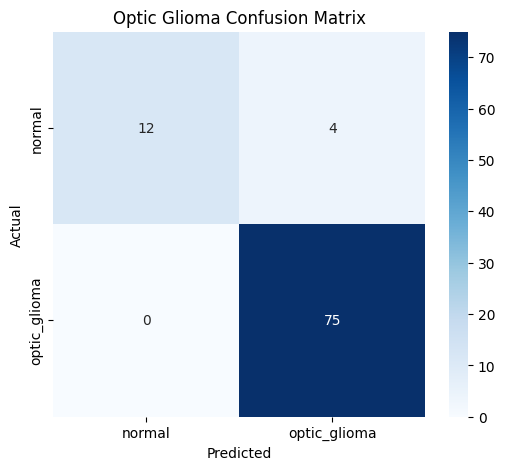

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=train_gen.class_indices.keys(),
    yticklabels=train_gen.class_indices.keys(),
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optic Glioma Confusion Matrix")
plt.show()
